In [1]:
import numpy as np
import pandas as pd
import load_data as ld
import preprocess as pre
from numpy.linalg import norm
import networkx as nx
import operator

def cos_similarity(lst1, lst2):
    return np.dot(lst1, lst2)/(norm(lst1)*norm(lst2))

def rescale(num, maxNum):
    return maxNum*num

def get_top_N(dict, n):
    sorted_dict = sorted(dict.items(), key=operator.itemgetter(1), reverse=True)[:n] #sorted(dict, key = dict.get, reverse=True)[:n]
    return sorted_dict

def get_adj(paragraphs, option, numNode, scale):
    
    nouns_comb, nouns_paras, nouns_stcs = pre.preprocessing(paragraphs) 
    dic_comb = pre.make_dic_count(nouns_comb)
    dic_paras = list(map(pre.make_dic_count, nouns_paras))
    dic_stcs = list(map(pre.get_stcs_dic, nouns_stcs))
    
    nouns_stcs = sum(nouns_stcs, [])
    dic_stcs = sum(dic_stcs, [])
    TopNList = get_top_N(dic_comb, numNode) 
    
    def get_vector(dictList, keyword):
        vector = []
        for dic in dictList:
            if keyword in dic.keys():
                vector.append(dic[keyword])
            else:
                vector.append(0)
        return vector
    
    N = len(TopNList)
    cotable = np.zeros((N, N))
        
    
    for i in range(N):
        for j in range(N):
            if (i!=j):
                left, right = TopNList[i][0], TopNList[j][0]
                if option == "ss":
                    for stc in nouns_stcs:
                        if left in stc and right in stc:
                            cotable[i][j] += 1        
                elif option == "ps":
                    for para in nouns_paras:
                        if left in para and right in para:
                            cotable[i][j] += 1  
                elif option == "scs":
                    Lvector = get_vector(dic_stcs, left)
                    Rvector = get_vector(dic_stcs, right)
                    cotable[i][j] = rescale(cos_similarity(Lvector, Rvector), scale)
                elif option == "pcs":
                    Lvector = get_vector(dic_paras, left)
                    Rvector = get_vector(dic_paras, right)
                    cotable[i][j] = rescale(cos_similarity(Lvector, Rvector), scale)
                else:
                    print("error : choose option among ('ss', 'ps', 'scs', 'pcs')")
    if option == "ss" or "ps":
        maxvalue = np.max(cotable)
        cotable = rescale(cotable / maxvalue, scale)
    return TopNList, cotable

In [25]:
title = "인공지능_이루다"
scale = 7
num_node = 10
option = "ss"
img_name = title + '_' + option + '_' + str(num_node)
paragraphs = ld.read_txt(title + ".txt")     # [ 문단1, 문단2, ...]
nodes, adj = get_adj(paragraphs, option, num_node, scale)

In [7]:
# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = 'C:\\WINDOWS\\Fonts\\malgunbd.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family=font_name)

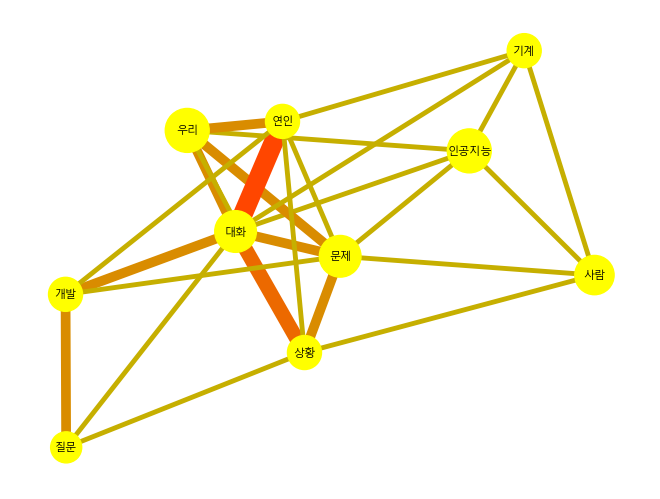

In [26]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

G = nx.Graph()
weighted_edges = []
attr_nodes = []
for i in range(len(nodes)):
    for j in range(i, len(nodes)):
        if(i!=j and adj[i][j] != 0):
            G.add_edge(nodes[i][0], nodes[j][0], weight=adj[i][j])
    attr_nodes.append((nodes[i]))#(i, {'name':nodes[i]}))
 
weights = nx.get_edge_attributes(G, "weight")
edges = G.edges()
nodeSize = [ t[1] for t in nodes ]
nodeSize = nodeSize / np.max(nodeSize) * 1000 

scaling_factor = 2 # to emphasise differences 
alphas = [(weights[edge]) * scaling_factor for edge in edges]
colors = [rgb_to_hex((int(75 * (weights[edge]/7))+180, int(140 * (1-weights[edge]/7))+70, 0  )) for edge in edges]

nx.draw_spring(G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)

In [5]:
plt.savefig(img_name+'.png')
plt.clf()

<Figure size 640x480 with 0 Axes>